<a href="https://colab.research.google.com/github/OlgaSzum/brama-face-demo/blob/main/notebooks/face_matching_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# === 0) Instalacja zależności (jeden raz na sesję) ===

In [ ]:
"""
Ta komórka instaluje dokładne wersje bibliotek potrzebnych do działania demo,
aby kod działał powtarzalnie w każdej sesji Colab.

Wyjaśnienia:
- deepface     → biblioteka do tworzenia embeddingów twarzy + wrapper do detektorów
- retina-face  → jeden z detektorów twarzy (dokładny, nowoczesny)
- mtcnn        → alternatywny detektor twarzy (bardziej klasyczny)
- tqdm         → paski postępu w dłuższych pętlach

Uwaga:
Możesz zobaczyć ostrzeżenie o wersji tqdm (resolver conflict).
W tym demo jest ono nieszkodliwe.
Jeśli chcesz, możesz podbić wersję do >=4.67,
np. zamieniając 'tqdm==4.66.4' na 'tqdm==4.67.1'.
"""

!pip -q install deepface==0.0.93 retina-face==0.0.14 mtcnn==0.1.1 tqdm==4.66.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.66.4 which is incompatible.


## 1)  Montowanie Drive i definiowanie ścieżek roboczych

In [ ]:
# === 1) Montowanie dysku Google + wybór plików/folderów + podgląd miniatury ===

# 1) Montowanie Google Drive w Colabie.
# 2) Utworzenie folderów projektu (reference, gallery, outputs, cache).
# 3) Definicja funkcji pomocniczych do listowania obrazów i katalogów.
# 4) Przygotowanie interfejsu użytkownika (dropdowny + miniatura).
# 5) Reakcje (callbacki) na wybór obrazu referencyjnego i folderu galerii.
# 6) Ustawienia początkowe, jeśli foldery już zawierają dane.
# 7) Wyświetlenie interfejsu i podsumowanie ścieżek.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, io
from pathlib import Path
from IPython.display import display, clear_output
import ipywidgets as widgets
from PIL import Image

# ---- CONFIG ----
ROOT_DIR    = "/content/drive/MyDrive/Brama_AI_Demo"
KNOWN_DIR   = f"{ROOT_DIR}/reference"
DEFAULT_GAL = f"{ROOT_DIR}/gallery"
OUT_DIR     = f"{ROOT_DIR}/outputs_demo"
CACHE_DIR   = f"{ROOT_DIR}/cache_demo"

for p in [ROOT_DIR, KNOWN_DIR, DEFAULT_GAL, OUT_DIR, CACHE_DIR]:
    os.makedirs(p, exist_ok=True)

IMG_EXT = {".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff"}

def list_images(d):
    p = Path(d)
    if not p.exists(): return []
    return sorted([str(x) for x in p.rglob("*") if x.suffix.lower() in IMG_EXT])

def list_candidate_galleries(root=ROOT_DIR):
    cands = set()
    if Path(DEFAULT_GAL).exists():
        cands.add(DEFAULT_GAL)
    for sub in Path(root).iterdir():
        if sub.is_dir():
            # uznaj katalog za „galerię”, jeśli ma choć 1 obraz
            for x in sub.rglob("*"):
                if x.is_file() and x.suffix.lower() in IMG_EXT:
                    cands.add(str(sub))
                    break
    return sorted(cands) if cands else [DEFAULT_GAL]

# --- UI widgets ---
ref_label = widgets.HTML("<b>1) Choose reference image</b>")
gal_label = widgets.HTML("<b>2) Choose gallery folder</b>")

ref_dd = widgets.Dropdown(options=list_images(KNOWN_DIR), description="Reference", layout=widgets.Layout(width="600px"))
gal_dd = widgets.Dropdown(options=list_candidate_galleries(), description="Gallery", layout=widgets.Layout(width="600px"))

status_out  = widgets.Output()
thumb_out   = widgets.Output()  # tu pokażemy miniaturę

# --- global vars updated live ---
QUERY_PATH  = None
GALLERY_DIR = None

def render_thumbnail(path, max_w=360):
    """Wyświetl miniaturę w thumb_out (bez crashy, z autoskalą)."""
    with thumb_out:
        clear_output(wait=True)
        if not path or not os.path.exists(path):
            print("No reference selected.")
            return
        try:
            im = Image.open(path).convert("RGB")
            w, h = im.size
            if w > max_w:
                im = im.resize((max_w, int(h * (max_w / w))))
            buf = io.BytesIO()
            im.save(buf, format="JPEG", quality=85)
            buf.seek(0)
            display(widgets.HTML(f"<div style='margin:6px 0 8px'><b>Selected:</b> {Path(path).name}</div>"))
            display(widgets.Image(value=buf.getvalue(), format='jpeg'))
        except Exception as e:
            print("Could not preview image:", e)

def on_ref_change(change):
    global QUERY_PATH
    if change["new"]:
        QUERY_PATH = change["new"]
        with status_out:
            clear_output(wait=True)
            print("Reference set.")
        render_thumbnail(QUERY_PATH)

def on_gal_change(change):
    global GALLERY_DIR
    if change["new"]:
        GALLERY_DIR = change["new"]
        # policz ile obrazów w wybranej galerii
        count = len(list_images(GALLERY_DIR)) if os.path.exists(GALLERY_DIR) else 0
        with status_out:
            clear_output(wait=True)
            print(f"Gallery set: {GALLERY_DIR}  (images: {count})")

ref_dd.observe(on_ref_change, names="value")
gal_dd.observe(on_gal_change, names="value")

# Inicjalne ustawienia (jeśli coś już jest w folderach)
if ref_dd.options:
    ref_dd.value = ref_dd.options[0]  # wywoła on_ref_change i pokaże miniaturę
if gal_dd.options:
    gal_dd.value = gal_dd.options[0]  # wywoła on_gal_change i policzy obrazy

display(widgets.VBox([ref_label, ref_dd, thumb_out, gal_label, gal_dd, status_out]))

print("Folders ready.")
print("ROOT_DIR   :", ROOT_DIR)
print("KNOWN_DIR  :", KNOWN_DIR)
print("DEFAULT_GAL:", DEFAULT_GAL)
print("OUT_DIR    :", OUT_DIR)
print("CACHE_DIR  :", CACHE_DIR)

Mounted at /content/drive


Folders ready.
ROOT_DIR   : /content/drive/MyDrive/Brama_AI_Demo
KNOWN_DIR  : /content/drive/MyDrive/Brama_AI_Demo/reference
DEFAULT_GAL: /content/drive/MyDrive/Brama_AI_Demo/gallery
OUT_DIR    : /content/drive/MyDrive/Brama_AI_Demo/outputs_demo
CACHE_DIR  : /content/drive/MyDrive/Brama_AI_Demo/cache_demo


## 2) Obliczanie embeddingów i zapisywanie w cache

In [ ]:
# === 2) Funkcje pomocnicze: cache + embeddingi + dystans ===
# Funkcje pomocnicze: zarządzanie cache, generowanie embeddingów twarzy, obliczanie dystansów i wybór najlepszych dopasowań

import numpy as np
from tqdm import tqdm

# --- Ustawienia globalne ---
# Ustawienia modelu, metryki podobieństwa i progów filtrowania wyników
MODEL_NAME  = "Facenet512"   # stabilny i CPU-friendly model (możesz zmienić np. na "ArcFace")
DIST_METRIC = "cosine"       # "cosine"
TOPK        = 20   # ile najlepszych wyników pokazujemy
SAVE_EVERY  = 50   # co ile zdjęć zapisywać partial CSV
MATCH_THRESHOLD = 0.5 # maksymalny dopuszczalny dystans (cosine)
MAX_RESULTS     = 5  # ile wyników trafi do raportu po filtrze

IMG_EXT = {".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff"}

# Zwraca listę wszystkich obrazów w katalogu (rekurencyjnie) z dozwolonymi rozszerzeniami
def list_images(d):
    p = Path(d)
    return sorted([str(x) for x in p.rglob("*") if x.suffix.lower() in IMG_EXT])

# Tworzy unikalny podpis pliku (ścieżka + czas modyfikacji + rozmiar) → do kontroli zmian w cache
def file_sig(path):
    """Podpis pliku do cache (ścieżka + mtime + rozmiar)."""
    st = os.stat(path)
    raw = f"{path}|{st.st_mtime_ns}|{st.st_size}".encode("utf-8", "ignore")
    return hashlib.md5(raw).hexdigest()

# Generuje ścieżkę do pliku cache dla danego obrazu i modelu
def cache_path_for(img_path, model=MODEL_NAME):
    sig = file_sig(img_path)
    base = hashlib.md5(img_path.encode()).hexdigest()[:12]
    return os.path.join(CACHE_DIR, f"{base}_{sig}_{model}.pkl")

# Próbuje wczytać embedding z pliku cache (jeśli istnieje i jest poprawny)
def load_cached_embedding(img_path, model=MODEL_NAME):
    cp = cache_path_for(img_path, model)
    if os.path.exists(cp):
        try:
            with open(cp, "rb") as f:
                return pickle.load(f)
        except Exception:
            return None
    return None

# Zapisuje embedding do pliku cache (zabezpieczenie plikiem tymczasowym)
def save_cached_embedding(img_path, emb, model=MODEL_NAME):
    cp = cache_path_for(img_path, model)
    tmp = cp + ".tmp"
    with open(tmp, "wb") as f:
        pickle.dump(emb, f, protocol=pickle.HIGHEST_PROTOCOL)
    os.replace(tmp, cp)

# Wylicza embedding twarzy z obrazu, z fallbackiem na różne detektory (opencv → mtcnn → retinaface), używa cache jeśli dostępny
def get_embedding(img_path, model=MODEL_NAME):
    """
    Zwraca embedding twarzy (np.ndarray) lub None.
    Próbuje kilku detektorów po kolei: opencv → mtcnn → retinaface.
    """
    cached = load_cached_embedding(img_path, model)
    if cached is not None:
        return cached

    backends = ["opencv", "mtcnn", "retinaface"]

    for backend in backends:
        try:
            reps = DeepFace.represent(
                img_path=img_path,
                model_name=model,
                detector_backend=backend,
                enforce_detection=False
            )
            if isinstance(reps, list) and len(reps) > 0 and "embedding" in reps[0]:
                emb = np.array(reps[0]["embedding"], dtype="float32")
                save_cached_embedding(img_path, emb, model)
                return emb
        except Exception:
            continue

    return None

# Oblicza odległość (dystans) między dwoma wektorami embeddingów: domyślnie metryka cosinusowa
def distance(a, b, metric=DIST_METRIC):
    if a is None or b is None:
        return np.inf
    a = np.asarray(a, dtype="float32")
    b = np.asarray(b, dtype="float32")
    if metric == "cosine":
        denom = (np.linalg.norm(a) * np.linalg.norm(b))
        if denom == 0:
            return np.inf
        return 1.0 - float(np.dot(a, b) / denom)
    return float(np.linalg.norm(a - b))

# Konwertuje obraz z formatu PIL (RGB) na tablicę numpy (BGR) dla DeepFace
def _pil_to_bgr_array(pil_img):
    """PIL.Image (RGB) -> numpy array (BGR) dla DeepFace."""
    arr = np.array(pil_img)  # RGB
    if arr.ndim == 2:  # szaroskalowe
        arr = np.stack([arr, arr, arr], axis=-1)
    # konwersja do BGR
    return arr[:, :, ::-1].copy()

# Dla obrazu referencyjnego: wybiera największą twarz, robi crop i embedding; fallback: całe zdjęcie
def get_reference_embedding_strict(img_path, model=MODEL_NAME):
    """
    Wyciąga embedding REFERENCJI z największej twarzy (crop).
    - detekcja wszystkich twarzy,
    - wybór największej,
    - konwersja cropa do numpy BGR,
    - Fallback: jeśli się nie uda, spróbuj klasycznego get_embedding(img_path).
    """
    faces = _extract_faces_all(img_path)
    if faces:
        faces.sort(key=lambda f: f["bbox"]["w"] * f["bbox"]["h"], reverse=True)
        crop = faces[0]["crop"]  # PIL.Image (RGB)
        # Upscale dla bardzo małych twarzy
        short = min(crop.size)
        if short < 300:
            scale = 400.0 / short
            crop = crop.resize((int(crop.width*scale), int(crop.height*scale)))
        np_bgr = _pil_to_bgr_array(crop)
        try:
            reps = DeepFace.represent(
                img_path=np_bgr,   # UWAGA: podajemy tablicę numpy (BGR)
                model_name=model,
                detector_backend="opencv",
                enforce_detection=False
            )
            if isinstance(reps, list) and reps and "embedding" in reps[0]:
                return np.array(reps[0]["embedding"], dtype="float32")
        except Exception:
            pass
    # Fallback – spróbuj całego obrazu:
    return get_embedding(img_path, model)

# Dla obrazu kandydata: wykrywa wszystkie twarze, liczy embedding dla każdego cropa i zwraca najlepsze (najmniejszy dystans) dopasowanie
def best_match_in_image(query_emb, cand_path, model=MODEL_NAME):
    """
    Dla obrazu-kandydata:
      - wykryj wszystkie twarze,
      - wylicz embedding dla każdego cropa (numpy BGR),
      - zwróć (najmniejszy dystans, bbox tej twarzy).
    Jeśli brak twarzy lub query_emb=None → (inf, None).
    """
    faces = _extract_faces_all(cand_path)
    if not faces or query_emb is None:
        return float("inf"), None

    best_d = float("inf")
    best_bbox = None
    for f in faces:
        crop = f["crop"]  # PIL.Image
        short = min(crop.size)
        if short < 300:
            scale = 400.0 / short
            crop = crop.resize((int(crop.width*scale), int(crop.height*scale)))
        np_bgr = _pil_to_bgr_array(crop)
        try:
            reps = DeepFace.represent(
                img_path=np_bgr,
                model_name=model,
                detector_backend="opencv",
                enforce_detection=False
            )
            if isinstance(reps, list) and reps and "embedding" in reps[0]:
                emb = np.array(reps[0]["embedding"], dtype="float32")
                d = distance(query_emb, emb, DIST_METRIC)
                if d < best_d:
                    best_d = d
                    best_bbox = f["bbox"]
        except Exception:
            continue
    return best_d, best_bbox

## 3) Wykrywanie twarzy, tworzenie ramek i cropów

In [ ]:
# === 3) Detekcja twarzy + ramki i croppy (zielone) ===

# 1) Wykrywanie wszystkich twarzy w obrazie (_extract_faces_all).
# 2) Wycinanie (crop) twarzy i zapisywanie ich jako osobne pliki JPG.
# 3) Tworzenie wersji annotated – oryginalny obraz z zieloną ramką wokół twarzy.
# 4) Obsługę zarówno automatycznej detekcji, jak i ręcznie podanego bboxa (override_bbox).
# 5) Fallback: jeśli cv2 nie odczyta obrazu → użycie PIL.
# Wynikiem są zawsze dwa pliki: *_boxed.jpg (annotated) oraz *_crop.jpg (crop twarzy).

from PIL import Image, ImageDraw
import io
import cv2

# Funkcja: detekcja wszystkich twarzy w obrazie
def _extract_faces_all(img_path):
    """Zwraca listę wpisów {'bbox':{'x','y','w','h'}, 'crop':PIL.Image} dla wszystkich twarzy (z fallbackami)."""
    faces_all = []
    backends = ["opencv", "mtcnn", "retinaface"]  # kolejność prób detektorów
    for backend in backends:
        try:
            faces = DeepFace.extract_faces(img_path=img_path, detector_backend=backend, enforce_detection=False)
            if isinstance(faces, list) and len(faces) > 0:
                im = Image.open(img_path).convert("RGB")
                W, H = im.size
                for f in faces:
                    fa = f.get("facial_area", {})
                    if {"x","y","w","h"} <= set(fa.keys()):
                        x, y, w, h = int(fa["x"]), int(fa["y"]), int(fa["w"]), int(fa["h"])
                        # zabezpieczenie granic
                        x = max(0, x); y = max(0, y); w = max(1, w); h = max(1, h)
                        x2 = min(W, x + w); y2 = min(H, y + h)
                        faces_all.append({"bbox":{"x":x, "y":y, "w":x2-x, "h":y2-y}, "crop": im.crop((x, y, x2, y2))})
                if faces_all:
                    break  # mamy już twarze, nie szukamy dalej
        except Exception:
            continue
    return faces_all


# Funkcja: tworzenie annotated i cropa dla wybranej twarzy
def annotate_and_crop(img_path, out_stem, box_color=(0, 255, 0), box_thickness=3, max_w=1400, override_bbox=None):
    """
    Tworzy:
      - obraz z zielonym boxem (annotated)
      - crop twarzy (crop)
    Jeśli override_bbox podany (dict {'x','y','w','h'}) — to TEN boks będzie zaznaczony/wycięty.
    """
    os.makedirs(OUT_DIR, exist_ok=True)
    ann_path  = os.path.join(OUT_DIR, f"{out_stem}_boxed.jpg")
    crop_path = os.path.join(OUT_DIR, f"{out_stem}_crop.jpg")

    # wybór boksu i cropa
    bbox = None
    crop = None
    if override_bbox is not None:
        # użyj podanego
        bbox = override_bbox
        im = Image.open(img_path).convert("RGB")
        x, y, w, h = bbox["x"], bbox["y"], bbox["w"], bbox["h"]
        crop = im.crop((x, y, x + w, y + h))
    else:
        # wybierz największą wykrytą twarz
        faces = _extract_faces_all(img_path)
        if faces:
            faces.sort(key=lambda f: f["bbox"]["w"] * f["bbox"]["h"], reverse=True)
            bbox = faces[0]["bbox"]
            crop = faces[0]["crop"]
        else:
            return None, None

    # Rysowanie prostokąta i zapis obrazu annotated
    im_cv = cv2.imread(img_path)
    if im_cv is None:
        pim = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(pim)
        x, y, w, h = bbox["x"], bbox["y"], bbox["w"], bbox["h"]
        draw.rectangle([x, y, x + w, y + h], outline=(0, 255, 0), width=box_thickness)
        if pim.width > max_w:
            ratio = max_w / pim.width
            pim = pim.resize((int(pim.width * ratio), int(pim.height * ratio)))
        pim.save(ann_path, "JPEG", quality=90)
    else:
        x, y, w, h = bbox["x"], bbox["y"], bbox["w"], bbox["h"]
        cv2.rectangle(im_cv, (x, y), (x + w, y + h), (0, 255, 0), box_thickness)
        if im_cv.shape[1] > max_w:
            scale = max_w / im_cv.shape[1]
            im_cv = cv2.resize(im_cv, (int(im_cv.shape[1]*scale), int(im_cv.shape[0]*scale)))
        cv2.imwrite(ann_path, im_cv, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

    # Zapis cropa twarzy jako osobny plik JPG
    crop.save(crop_path, "JPEG", quality=92)
    return ann_path, crop_path

## 4) Obliczanie podobieństw, zapis CSV, wyniki posortowane wg podobieństwa

In [ ]:
# === 4) Pojedyncze zapytanie → przeszukiwanie galerii ===

# 1) Sprawdzenie, czy interfejs z dropdownami (komórka 1) został uruchomiony.
# 2) Pobranie ścieżki zdjęcia referencyjnego i folderu galerii z wyborów użytkownika.
# 3) Walidacja wejścia (czy pliki i foldery istnieją).
# 4) Zebranie listy wszystkich obrazów z galerii.
# 5) Obliczenie embeddingu twarzy ze zdjęcia referencyjnego (najpierw strict-crop, potem fallbacki).
# 6) Iteracja po obrazach z galerii:
#      - wykrycie twarzy,
#      - obliczenie embeddingu dla każdej,
#      - wybór twarzy o najmniejszym dystansie do referencji,
#      - zapisanie dystansu oraz bbox do wyników.
# 7) Zapisywanie wyników częściowych co SAVE_EVERY obrazów.
# 8) Zapisanie wyników końcowych do plików CSV i JSON.
# 9) Wyświetlenie podsumowania i kilku najlepszych dopasowań (TopK).

import os, csv, json, numpy as np
from deepface import DeepFace
from tqdm import tqdm

# Sprawdzenie, czy interfejs dropdownów był uruchomiony
if 'ref_dd' not in globals() or 'gal_dd' not in globals():
    raise SystemExit("⚠️ Najpierw uruchom komórkę 1 (Mount + dropdowns), potem tę komórkę.")

# Pobranie ścieżek z dropdownów
QUERY_PATH  = ref_dd.value if isinstance(ref_dd.value, str) else None
GALLERY_DIR = gal_dd.value if isinstance(gal_dd.value, str) else None

# Walidacja wejścia
if not QUERY_PATH or not os.path.exists(QUERY_PATH):
    raise SystemExit("⚠️ Brak zdjęcia referencyjnego. Wybierz je w dropdownie w komórce 1.")
if not GALLERY_DIR or not os.path.exists(GALLERY_DIR):
    raise SystemExit("⚠️ Brak folderu galerii. Wybierz go w dropdownie w komórce 1.")

print("Using reference image:", QUERY_PATH)
print("Using gallery folder :", GALLERY_DIR)

# Zebranie listy obrazów z galerii
gal_imgs = list_images(GALLERY_DIR)
if not gal_imgs:
    raise SystemExit(f"⚠️ No images found in {GALLERY_DIR}.")

# Funkcja pomocnicza do obliczania embeddingu referencyjnego
def ensure_reference_embedding(path):
    emb = get_reference_embedding_strict(path, MODEL_NAME)
    if emb is not None:
        print("Ref emb: OK via strict-crop")
        return emb
    tried = []
    for backend in ["opencv", "mtcnn", "retinaface"]:
        try:
            reps = DeepFace.represent(img_path=path, model_name=MODEL_NAME,
                                      detector_backend=backend, enforce_detection=False)
            ok = isinstance(reps, list) and len(reps)>0 and "embedding" in reps[0]
            tried.append(f"{backend}:{'OK' if ok else 'no-face'}")
            if ok:
                print("Ref emb: OK via", backend)
                return np.array(reps[0]["embedding"], dtype="float32")
        except Exception:
            tried.append(f"{backend}:error")
    print("Ref emb failed →", ", ".join(tried))
    return None

q_emb = ensure_reference_embedding(QUERY_PATH)
if q_emb is None:
    raise SystemExit("⚠️ Nie udało się wyciągnąć embeddingu z wybranego pliku. Wybierz inne zdjęcie w dropdownie i uruchom ponownie.")

# Iteracja po obrazach z galerii i zapisywanie wyników
results_csv = os.path.join(OUT_DIR, "demo_matches.csv")
partial_csv = os.path.join(OUT_DIR, "demo_matches_partial.csv")
bboxes_json = os.path.join(OUT_DIR, "demo_matches_bboxes.json")

rows, bbox_map, seen = [], {}, 0
for idx, g in enumerate(tqdm(gal_imgs, desc="Scoring gallery (multi-face)")):
    d, bb = best_match_in_image(q_emb, g, MODEL_NAME)
    rows.append([QUERY_PATH, g, d])
    if bb is not None:
        bbox_map[g] = bb
    seen += 1
    # Zapisywanie częściowych wyników co SAVE_EVERY obrazów lub na końcu
    if seen % SAVE_EVERY == 0 or idx == len(gal_imgs)-1:
        rows_sorted = sorted(rows, key=lambda r: r[2])
        with open(partial_csv, "w", newline="", encoding="utf-8") as f:
            w = csv.writer(f); w.writerow(["query","candidate",f"distance_{DIST_METRIC}"]); w.writerows(rows_sorted)
        with open(bboxes_json, "w", encoding="utf-8") as f:
            json.dump(bbox_map, f, ensure_ascii=False, indent=2)

# Zapis wyników końcowych do plików
rows_sorted = sorted(rows, key=lambda r: r[2])
with open(results_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f); w.writerow(["query","candidate",f"distance_{DIST_METRIC}"]); w.writerows(rows_sorted)
with open(bboxes_json, "w", encoding="utf-8") as f:
    json.dump(bbox_map, f, ensure_ascii=False, indent=2)

print("Saved CSV :", results_csv)
print("Saved BBOX:", bboxes_json)

# Podgląd kilku najlepszych dopasowań
topk = rows_sorted[:TOPK]
topk[:3]

Using reference image: /content/drive/MyDrive/Brama_AI_Demo/reference/100746_Zylberberg_Abram_1930-_Portret_mezczyzny.jpg
Using gallery folder : /content/drive/MyDrive/Brama_AI_Demo/gallery
Ref emb: OK via strict-crop


Scoring gallery (multi-face): 100%|██████████| 8/8 [00:29<00:00,  3.63s/it]

Saved CSV : /content/drive/MyDrive/Brama_AI_Demo/outputs_demo/demo_matches.csv
Saved BBOX: /content/drive/MyDrive/Brama_AI_Demo/outputs_demo/demo_matches_bboxes.json


[['/content/drive/MyDrive/Brama_AI_Demo/reference/100746_Zylberberg_Abram_1930-_Portret_mezczyzny.jpg',
  '/content/drive/MyDrive/Brama_AI_Demo/gallery/100768_Zylberberg_Abram_1930-_Portret_m_odego_mezczyzny.jpg',
  0.2762748599052429],
 ['/content/drive/MyDrive/Brama_AI_Demo/reference/100746_Zylberberg_Abram_1930-_Portret_mezczyzny.jpg',
  '/content/drive/MyDrive/Brama_AI_Demo/gallery/100999_Zylberberg_Abram_1930-_Trzej_m_odzi_mezczyzni.jpg',
  0.4633742570877075],
 ['/content/drive/MyDrive/Brama_AI_Demo/reference/100746_Zylberberg_Abram_1930-_Portret_mezczyzny.jpg',
  '/content/drive/MyDrive/Brama_AI_Demo/gallery/100732_Zylberberg_Abram_1930-_Trzy_m_ode_kobiety.jpg',
  0.47964388132095337]]

## 5) Generowanie raportu HTML z miniaturami i filtrowaniem wyników

Saved HTML report: /content/drive/MyDrive/Brama_AI_Demo/outputs_demo/demo_report.html
Filtered CSV: /content/drive/MyDrive/Brama_AI_Demo/outputs_demo/demo_matches_filtered.csv



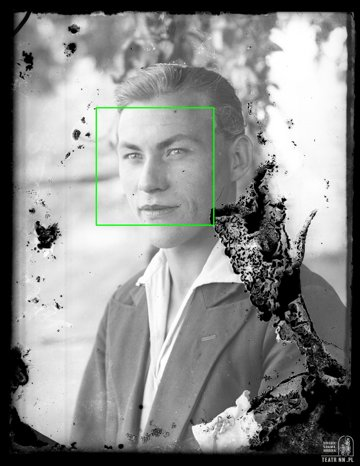
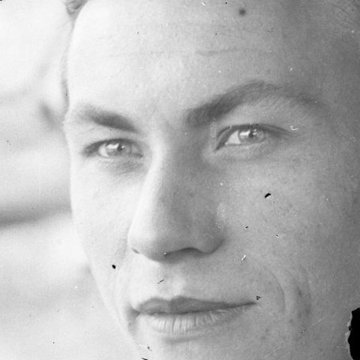
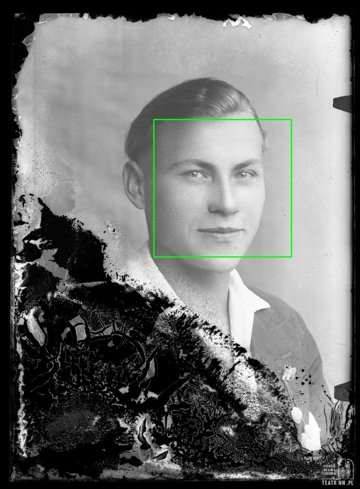
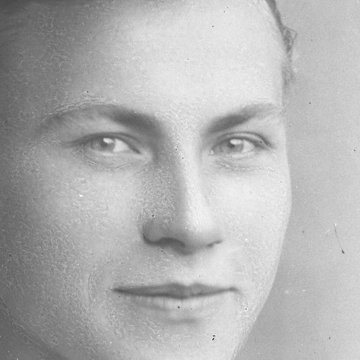
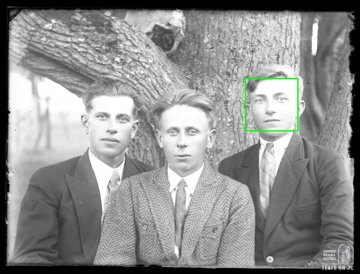
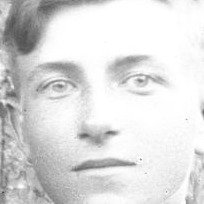
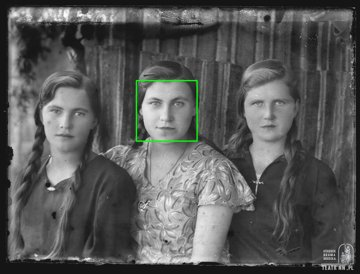
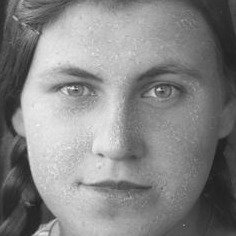

In [ ]:
# === 5) Raport HTML z progami + podglądem w Colabie ===

# 1) Przygotowanie ścieżek i funkcji pomocniczych (base64, ścieżki względne).
# 2) Wczytanie mapy bboxów i annotacja zdjęcia referencyjnego.
# 3) Filtrowanie dopasowań według progu i maksymalnej liczby wyników.
# 4) Annotacja i crop dla każdego dopasowania.
# 5) Generowanie raportu HTML z miniaturami i zapis do pliku.
# 6) Podgląd raportu w Colabie.

import os, html, json
from base64 import b64encode
from PIL import Image
from IPython.display import IFrame

html_path   = os.path.join(OUT_DIR, "demo_report.html")
bboxes_json = os.path.join(OUT_DIR, "demo_matches_bboxes.json")

def to_data_uri(img_path, max_w=360):
    if not img_path or not os.path.exists(img_path):
        return ""
    try:
        im = Image.open(img_path).convert("RGB")
        w, h = im.size
        if w > max_w:
            h2 = int(h * (max_w / w))
            im = im.resize((max_w, h2))
        import io
        buf = io.BytesIO()
        im.save(buf, format="JPEG", quality=85)
        return "data:image/jpeg;base64," + b64encode(buf.getvalue()).decode("ascii")
    except Exception:
        return ""

def base_and_rel(p):
    fn = os.path.basename(p)
    try:
        rel = os.path.relpath(p, ROOT_DIR) if p.startswith(ROOT_DIR) else p
    except Exception:
        rel = p
    return html.escape(fn), html.escape(rel)

# wczytaj mapę bboxów z komórki 3
cand_bbox = {}
if os.path.exists(bboxes_json):
    with open(bboxes_json, "r", encoding="utf-8") as f:
        cand_bbox = json.load(f)

# 1) Query: box + crop
q_ann, q_crop = annotate_and_crop(
    QUERY_PATH,
    out_stem=f"query_{Path(QUERY_PATH).stem}",
    box_color=(0,255,0),
    box_thickness=3
)

# 2) Filtr: tylko dopasowania pod progiem, max N
filtered = [r for r in rows_sorted if r[1] != QUERY_PATH and r[2] <= MATCH_THRESHOLD]
filtered = filtered[:MAX_RESULTS]

filtered_csv = os.path.join(OUT_DIR, "demo_matches_filtered.csv")
with open(filtered_csv, "w", newline="", encoding="utf-8") as f:
    import csv
    w = csv.writer(f); w.writerow(["query","candidate",f"distance_{DIST_METRIC}"]); w.writerows(filtered)

# 3) Przygotuj dopasowania: box + crop dla właściwego bboxa
annotated = []
for _, cand, dist in filtered:
    override = cand_bbox.get(cand)  # może być None
    ann, cr = annotate_and_crop(
        cand,
        out_stem=f"cand_{Path(cand).stem}",
        box_color=(0,255,0),
        box_thickness=3,
        override_bbox=override
    )
    annotated.append((cand, dist, ann, cr))

# 4) Generuj HTML
with open(html_path, "w", encoding="utf-8") as f:
    f.write("<html><head><meta charset='utf-8'><title>Face-Matching Demo</title>")
    f.write("""
    <style>
      body{font-family:sans-serif;max-width:1200px;margin:24px auto;line-height:1.35}
      .row{display:flex;gap:18px;align-items:flex-start;margin-bottom:18px}
      .col{display:flex;flex-direction:column;gap:8px}
      .score{min-width:120px;font-weight:bold}
      img{border-radius:8px;box-shadow:0 1px 6px rgba(0,0,0,.1)}
      .hdr{margin:6px 0 18px;font-size:20px;font-weight:700}
      .meta{font-size:12px;color:#666}
      .fn{font-weight:700}
      .pill{display:inline-block;padding:2px 8px;border-radius:999px;background:#e6f4ea;color:#137333;font-weight:700;font-size:12px}
      .warn{color:#b00020;font-weight:700}
    </style>
    """)
    f.write("</head><body>")

    # Query sekcja
    q_fn, q_rel = base_and_rel(QUERY_PATH)
    f.write("<div class='hdr'>Query</div>")
    f.write("<div class='row'>")
    if q_ann:  f.write(f"<div class='col'><div class='fn'>Annotated</div><img src='{to_data_uri(q_ann)}'></div>")
    if q_crop: f.write(f"<div class='col'><div class='fn'>Crop</div><img src='{to_data_uri(q_crop)}'></div>")
    f.write(f"<div class='col'><div class='fn'>{q_fn}</div><div class='meta'>{q_rel}</div>")
    f.write(f"<div class='meta'>Distance metric: <b>{DIST_METRIC}</b> | Threshold ≤ <b>{MATCH_THRESHOLD}</b> | Max results: <b>{MAX_RESULTS}</b></div></div>")
    f.write("</div>")

    # Wyniki
    f.write("<div class='hdr'>Matches</div>")
    if not annotated:
        f.write("<div class='warn'>No matches under the threshold.</div>")
    for cand, dist, ann, cr in annotated:
        c_fn, c_rel = base_and_rel(cand)
        f.write("<div class='row'>")
        f.write(f"<div class='score'><span class='pill'>{dist:.4f}</span></div>")
        if ann: f.write(f"<div class='col'><div class='fn'>Annotated</div><img src='{to_data_uri(ann)}'></div>")
        if cr:  f.write(f"<div class='col'><div class='fn'>Crop</div><img src='{to_data_uri(cr)}'></div>")
        f.write(f"<div class='col'><div class='fn'>{c_fn}</div><div class='meta'>{c_rel}</div></div>")
        f.write("</div>")
    f.write("</body></html>")

print("Saved HTML report:", html_path)
print("Filtered CSV:", filtered_csv)

# --- Mini-podgląd w Colabie ---
from IPython.display import HTML
display(HTML(filename=html_path))

## 6) Pobieranie raportu HTML na komputer lokalny

In [ ]:
from google.colab import files
files.download(html_path)   # html_path = ścieżka do pliku raportu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>